In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

Considering full MNIST dataset

In [0]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/models'),
 PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/4/24019.png')

In [0]:
defaults.cmap='binary'

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

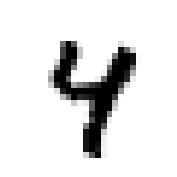

In [9]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/9')]

In [13]:
ll = sd.label_from_folder()
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Test: None

4 torch.Size([1, 28, 28])


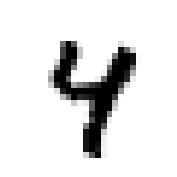

In [14]:
x,y = ll.train[0]
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
ll = ll.transform(tfms)

In [0]:
bs = 128
data = ll.databunch(bs=bs).normalize()

4


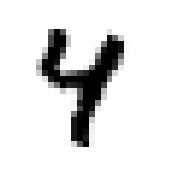

In [17]:
x,y = data.train_ds[0]
x.show()
print(y)

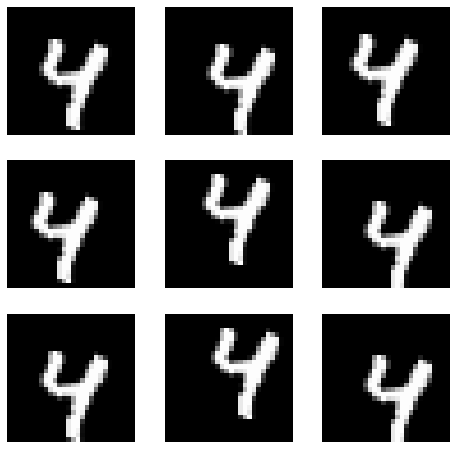

In [18]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [19]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

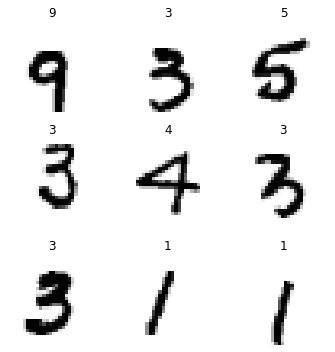

In [20]:
data.show_batch(rows=3, figsize=(5,5))

###Basic CNN with BatchNorm

In [0]:
def conv(ni,nf): 
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [24]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [25]:
xb = xb.cuda()
model(xb).shape

torch.Size([128, 10])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


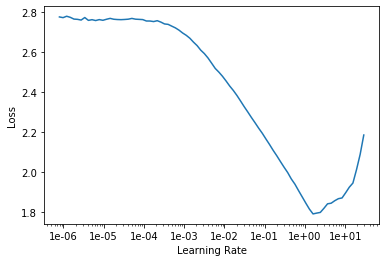

In [26]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229952,0.427419,0.863200,00:27
1,0.127542,0.102424,0.966500,00:27
2,0.073354,0.038063,0.987400,00:26


###Using conv_layer from fastai

In [28]:
doc(conv_layer)

The conv_layer function returns a sequence of nn.Conv2D, BatchNorm and a ReLU 

In [0]:
def conv2(ni,nf): 
  return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.086293,0.063358,0.980000,00:26
1,0.142277,0.097264,0.969900,00:26
2,0.130105,0.202120,0.931700,00:26
3,0.112980,0.177840,0.943600,00:26
4,0.105768,0.162855,0.943000,00:26
5,0.094893,0.093603,0.974600,00:25
6,0.081994,0.047581,0.985100,00:26
7,0.058100,0.032375,0.990000,00:26
8,0.048354,0.027341,0.991400,00:26
9,0.036943,0.024640,0.992300,00:25


###Resnet-ish

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [40]:
doc(res_block)

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): 
  return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


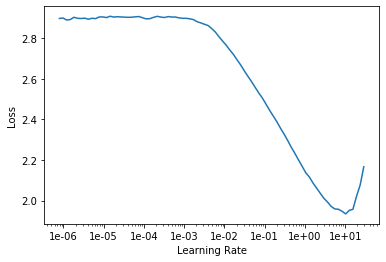

In [38]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.237642,0.281209,0.910900,00:28
1,0.130005,0.140264,0.953600,00:28
2,0.116131,0.090762,0.971600,00:28
3,0.085506,0.075851,0.976300,00:28
4,0.078955,0.058394,0.983100,00:28
5,0.056658,0.046464,0.985000,00:28
6,0.058731,0.034967,0.989400,00:28
7,0.045908,0.028289,0.991100,00:28
8,0.035349,0.031037,0.991200,00:28
9,0.027726,0.016587,0.994800,00:28
